# Optimizing two models at once 

One might be interested in optimizing for two "compteting" models at the same time. Consider having 3 separate samples A, B, C and we'd be interesting in extracting the significance for two out of the three at the same time. Two models would be fitted, e.g one where A is signal and B & C are backgrounds and one where B is signal and A & C are backgrounds. This example shows how to optimize for both of them at the same time.

In [ ]:
import jax
import neos.makers as makers
import neos.cls as cls
import numpy as np
import jax.experimental.stax as stax
import jax.experimental.optimizers as optimizers
import jax.random
import time

### Initialise network using `jax.experimental.stax`

In [ ]:
NOUT = 3
init_random_params, predict = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(NOUT),
    stax.Softmax,
)

### Initialse tools from `neos`:

The way we initialise in `neos` is to define functions that make a statistical model from histograms, which in turn are themselves made from a predictive model, such as a neural network. Here's some detail on the unctions used below:

- `hists_from_nn_three_blobs(predict)` uses the nn decision function `predict` defined in the cell above to form histograms from signal and background data, all drawn from multivariate normal distributions with different means. Two background distributions are sampled from, which is meant to mimic the situation in particle physics where one has a 'nominal' prediction for a nuisance parameter and then an alternate value (e.g. from varying up/down by one standard deviation), which then modifies the background pdf. Here, we take that effect to be a shift of the mean of the distribution. The value for the background histogram is then the mean of the resulting counts of the two modes, and the uncertainty can be quantified through the count standard deviation.
- `nn_hepdata_like(hmaker)` uses `hmaker` to construct histograms, then feeds them into the `neos.models.hepdata_like` function that constructs a pyhf-like model. This can then be used to call things like `logpdf` and `expected_data` downstream.
- `cls_maker` takes a model-making function as it's primary argument, which is fed into functions from `neos.fit` that minimise the `logpdf` of the model in both a constrained (fixed parameter of interest) and a global way. Moreover, these fits are wrapped in a function that allows us to calculate gradients through the fits using *fixed-point differentiation*. This allows for the calculation of both the profile likelihood and its gradient, and then the same for $\mathsf{cl_s}$ :)

- `cls_maker2` is an function returning the sum "loss" for two models instead of one in `cls_maker`. Ideally this would be achievable as `cls_maker(model1)` + `cls_maker(model2)` but that kind of implementation is currently resisting me.

All three of these methods return functions. in particular, `cls_maker` returns a function that differentiably calculates $\mathsf{cl_s}$ values, which is our desired objective to minimise.

In [ ]:
hmaker = makers.hists_from_nn_three_samples(predict, group=1)
nnm = makers.nn_hepdata_like(hmaker)

hmaker2 = makers.hists_from_nn_three_samples(predict, group=2)
nnm2 = makers.nn_hepdata_like(hmaker2)

loss = cls.cls_maker2(nnm, nnm2, solver_kwargs=dict(pdf_transform=True))

### Randomly initialise nn weights and check that we can get the gradient of the loss wrt nn params

In [ ]:
_, network = init_random_params(jax.random.PRNGKey(2), (-1, 2))

loss(network,1.)

/home/anovak/software/miniconda3/envs/neos/lib/python3.7/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray(0.11805832, dtype=float64)

In [ ]:
nnm.hm(network)

(DeviceArray([3.18638394, 3.35764529, 3.45597077], dtype=float64),
 DeviceArray([6.6221433 , 7.01013934, 6.36771735], dtype=float64),
 DeviceArray([2.57335254, 2.64766677, 2.52343364], dtype=float64),
 DeviceArray([3.18638394, 3.35764529, 3.45597077], dtype=float64),
 (DeviceArray([3.14655908, 3.73641724, 3.11702368], dtype=float64),
  DeviceArray([3.47558423, 3.2737221 , 3.25069367], dtype=float64)))

In [ ]:
a, b, c, d, e = nnm.hm(network)

### Define training loop!

In [ ]:
#jit_loss = jax.jit(loss)

opt_init, opt_update, opt_params = optimizers.adam(.5e-3)

def train_network(N, cont=False, network=None):
    if not cont:
        _, network = init_random_params(jax.random.PRNGKey(4), (-1, 2))
    if network is not None:
        network = network
    losses = []
    cls_vals = []
    state = opt_init(network)
    
    # parameter update function
    #@jax.jit
    def update_and_value(i, opt_state, mu, loss_choice):
        net = opt_params(opt_state)
        value, grad = jax.value_and_grad(loss_choice)(net, mu)
        return opt_update(i, grad, state), value, net
    
    for i in range(N):
        start_time = time.time()
        loss_choice = loss
        state, value, network = update_and_value(i,state,1.0, loss_choice)
        epoch_time = time.time() - start_time
        losses.append(value)
        metrics = {"loss": losses}
        yield network, metrics, epoch_time

### Plotting helper function for awesome animations :)

In [ ]:
# Choose colormap
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
def to_transp(cmap):
    #cmap = pl.cm.Reds_r
    my_cmap = cmap(np.arange(cmap.N))
    #my_cmap[:,-1] = np.geomspace(0.001, 1, cmap.N)
    my_cmap[:,-1] = np.linspace(0, 0.7, cmap.N)
    #my_cmap[:,-1] = np.ones(cmap.N)
    return ListedColormap(my_cmap)

def plot(axarr, network, metrics, hm, hm2, maxN, ith):
    xlim = (-5, 5)
    ylim = (-5, 5)
    g = np.mgrid[xlim[0]:xlim[1]:101j, ylim[0]:ylim[1]:101j]
    levels = np.linspace(0, 1, 20)
        
    ax = axarr[0]
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, NOUT)[:, :, 0],
        levels=levels,
        cmap = to_transp(pl.cm.Reds),
    )
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, NOUT)[:, :, 1],
        levels=levels,
        cmap = to_transp(pl.cm.Greens),
    )
    if NOUT > 2:
        ax.contourf(
            g[0],
            g[1],
            predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 3)[:, :, 2],
            levels=levels,
            cmap = to_transp(pl.cm.Blues),
        )
    
    #print(list(map(len, [hm.sig1[:, 0], hm.sig2[:, 0], hm.bkg[:, 0]])))
    ax.scatter(hm.sig1[:, 0], hm.sig1[:, 1], alpha=0.25, c="C9", label="sig1")
    ax.scatter(hm.sig2[:, 0], hm.sig2[:, 1], alpha=0.17, c="C8", label="bkg2")
    ax.scatter(hm.bkg[:, 0], hm.bkg[:, 1], alpha=0.17, c="C1", label="bkg2")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax = axarr[1]
    ax.axhline(0.05, c="slategray", linestyle="--")
    ax.plot(metrics["loss"][:ith], c="steelblue", linewidth=2.0)

    ax.set_ylim(0, metrics["loss"][0])
    ax.set_xlim(0, maxN)
    ax.set_xlabel("epoch")
    ax.set_ylabel(r"$cl_s$")

    ax = axarr[2]
    s, b, db, sig, bs = hm(network)
    ytop = np.max(np.sum([s, b], axis=0))*1.3
    ax.bar(range(NOUT), sig, bottom=bs[0]+bs[1], color="C9", label="Sample 1")
    ax.bar(range(NOUT), bs[0], bottom=bs[1], color="C8", label="Sample 2")
    ax.bar(range(NOUT), bs[1], color="C1", label="Sample 3")
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")
    ax.set_title("Raw histograms")
    ax.set_ylim(0, ytop)
    if ith == 0:
        ax.legend()
        
    ax = axarr[3]
    s, b, db, sig, bs = hm(network)
    ax.bar(range(NOUT), s, bottom=b, color="#722620", label="sig", alpha=0.9)
    ax.bar(range(NOUT), b, color="#F2BC94", label="bkg")
    ax.bar(range(NOUT), db, bottom=b - db / 2.0, alpha=0.3, color="black", label="bkg error", hatch='////')
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")
    ax.set_title("Model 1: sig1 vs (sig2 + bkg)")
    ax.set_ylim(0, ytop)
    if ith == 0:
        ax.legend()
        
    ax = axarr[4]
    s, b, db, sig, bs = hm2(network)
    ax.bar(range(NOUT), s, bottom=b, color="#722620", label="sig")
    ax.bar(range(NOUT), b, color="#F2BC94", label="bkg")
    ax.bar(range(NOUT), db, bottom=b - db / 2.0, alpha=0.3, color="black", label="bkg error", hatch='////')
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")
    ax.set_title("Model 2: sig2 vs (sig1 + bkg)")
    ax.set_ylim(0, ytop)
    if ith == 0:
        ax.legend()


### Let's run it!!

epoch 0: CLs = 0.11753656992080241, took 13.775112867355347s
epoch 1: CLs = 0.08209403877337929, took 8.045371532440186s
epoch 2: CLs = 0.044005125298022696, took 7.101398229598999s
epoch 3: CLs = 0.019274968461462372, took 6.06639289855957s
epoch 4: CLs = 0.008274224309383627, took 6.036885976791382s
epoch 5: CLs = 0.003938565024906415, took 6.06868052482605s
epoch 6: CLs = 0.0021442851251043393, took 6.421098470687866s
epoch 7: CLs = 0.0013138429032653054, took 6.986356973648071s
epoch 8: CLs = 0.0008851344623921342, took 6.7660839557647705s
epoch 9: CLs = 0.0006428453895075403, took 6.622220039367676s


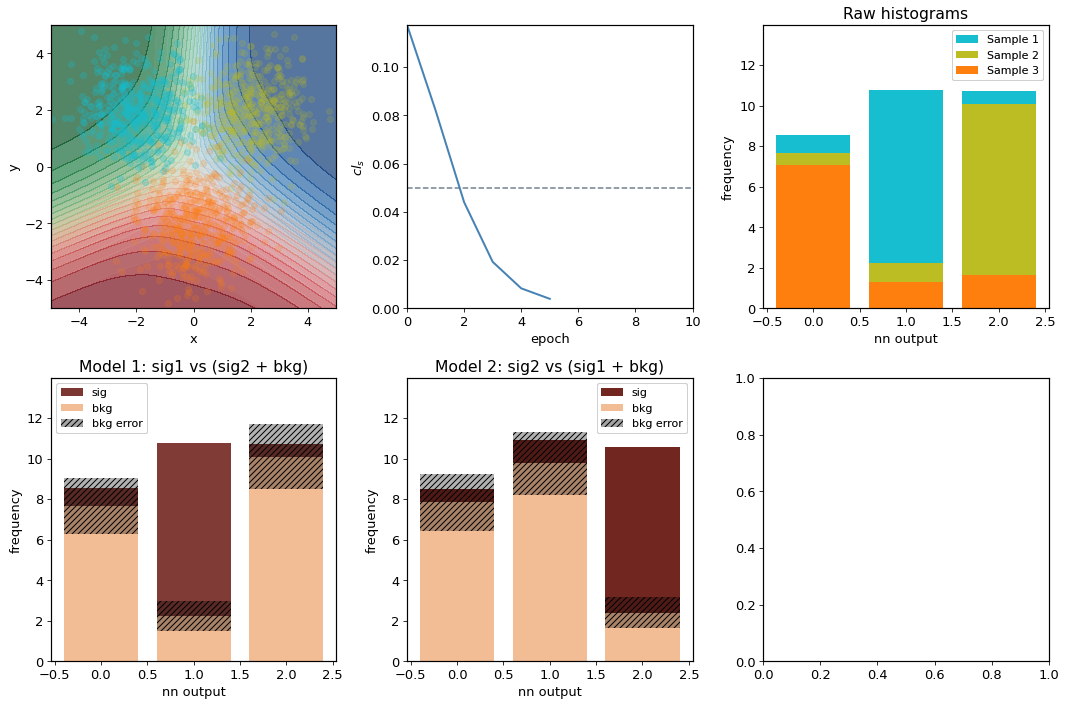

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera
from IPython.display import HTML

plt.rcParams.update(
    {
        "axes.labelsize": 13,
        "axes.linewidth": 1.2,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "figure.figsize": [7.2, 3.0],
        "font.size": 13,
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "legend.fontsize": 11,
    }
)


fig, axarr = plt.subplots(2, 3)
axarr = axarr.flatten()
fig.set_size_inches(15, 10)
camera = Camera(fig)

maxN = 10 # make me bigger for better results!

animate = True # animations fail tests

# Training
for i, (network, metrics, epoch_time) in enumerate(train_network(maxN)):
    print(f"epoch {i}:", f'CLs = {metrics["loss"][-1]}, took {epoch_time}s')
    if animate:
        if i % 6 == 0:
            plot(axarr, network, metrics, nnm.hm, nnm2.hm, maxN=maxN, ith=i)
            plt.tight_layout()
            camera.snap()
            camera.animate().save("animation.gif", writer="imagemagick", fps=6)
            #HTML(camera.animate().to_html5_video())
if animate:
    camera.animate().save("animation.gif", writer="imagemagick", fps=6)